This tutorial will build and build a basic character-level recurrent neuron network (RNN) to classify words.  A character-level RNN reads words as a series of characters - outputing a prediction and `hidden state` at each step, feeding it's previous hidden into each next step.

[tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [ ]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

name_files = findFiles('data/names/names/*.txt')
print(name_files)

['data/names/names/Czech.txt', 'data/names/names/German.txt', 'data/names/names/Arabic.txt', 'data/names/names/Japanese.txt', 'data/names/names/Chinese.txt', 'data/names/names/Vietnamese.txt', 'data/names/names/Russian.txt', 'data/names/names/French.txt', 'data/names/names/Irish.txt', 'data/names/names/English.txt', 'data/names/names/Spanish.txt', 'data/names/names/Greek.txt', 'data/names/names/Italian.txt', 'data/names/names/Portuguese.txt', 'data/names/names/Scottish.txt', 'data/names/names/Dutch.txt', 'data/names/names/Korean.txt', 'data/names/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [18]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [23]:
print(f"All categories are {all_categories}")
print(f"Number of categories is {n_categories}")

All categories are ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
Number of categories is 18


In [24]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [26]:
print(f"All letters are {all_letters}")

All letters are abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


now we have all the names organized, we need to turn them into `tensors` to make any use of them. 

To present a single letter, we use a `one-hot vector` of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of current letter. e.g. "b" = <0 1 0 0 0 ...>

In [30]:
import torch

# find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# just for demostration, turn a letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# turn a line into a <line_length x 1 x n_letters> array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToIndex('J'))
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

35
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the network

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

for the sake of efficiency, we don't want to creating a new tensor for every step, so we will use `lineToTensor` instead of `letterToTensor`.

In [36]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8823, -2.9643, -2.8610, -3.0199, -2.9341, -2.9806, -2.9144, -2.6590,
         -2.9014, -2.9937, -2.6118, -3.0341, -3.0380, -2.8550, -2.8293, -2.7763,
         -3.0361, -2.8683]], grad_fn=<LogSoftmaxBackward0>)


## Prepare for training

In [37]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 10)


In [39]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f"category = {category} / line = {line}")

category = Arabic / line = Sabbag
category = Korean / line = Ko
category = French / line = Bonfils
category = Polish / line = Jagoda
category = Italian / line = Fiore
category = English / line = Thorpe
category = Greek / line = Paraskos
category = English / line = Kromberg
category = Irish / line = Damhain
category = Spanish / line = Iniguez


In [45]:
criterion = nn.NLLLoss()

In [46]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [48]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'v' if guess == category else 'x (%s)' % category
        print(f"{iter} {iter / n_iters * 100} {timeSince(start)} {loss} {line} {guess} {correct}")

    if iter & plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0 0m 2s 2.471857786178589 Gensch Polish x (German)
10000 10.0 0m 4s 2.1092476844787598 Cunningham Russian x (Scottish)
15000 15.0 0m 7s 1.7017964124679565 Granger French v
20000 20.0 0m 10s 1.032055139541626 Shalhoub Arabic v
25000 25.0 0m 12s 1.8210861682891846 Nadwornik Russian x (Czech)
30000 30.0 0m 15s 2.40327525138855 Van tonder Russian x (German)
35000 35.0 0m 17s 3.3874006271362305 D'cruze French x (Portuguese)
40000 40.0 0m 20s 2.6506471633911133 Kim Korean x (Vietnamese)
45000 45.0 0m 22s 2.7607338428497314 Rompaij French x (Dutch)
50000 50.0 0m 24s 2.644517183303833 Schuhart Scottish x (German)
55000 55.00000000000001 0m 27s 2.1148898601531982 Cohen Irish x (English)
60000 60.0 0m 31s 1.064677357673645 Yong Korean x (Chinese)
65000 65.0 0m 34s 2.7014527320861816 Horowitz Polish x (German)
70000 70.0 0m 36s 3.549651622772217 Abragam French x (Russian)
75000 75.0 0m 39s 0.020045205950737 Fabrichnov Russian v
80000 80.0 0m 41s 0.006944922264665365 Vassilikos Greek v
8500

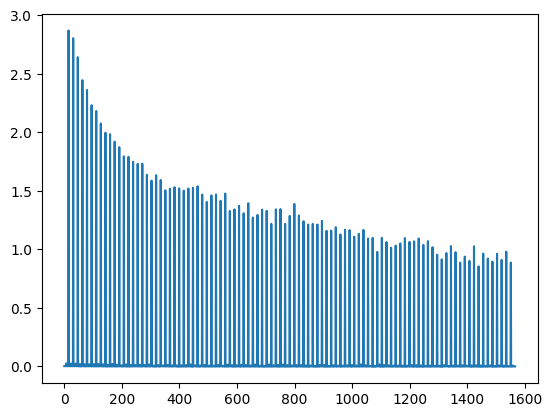

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)